In [1]:
import os
import shutil
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy.io.wavfile as wavfile
import scipy.signal as signal

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras import layers, models

In [2]:
FILE_PATH = './donateacry_corpus'
dataset = pathlib.Path(FILE_PATH)
cry_list = np.array(tf.io.gfile.listdir(str(dataset)))
print(cry_list) 

['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [3]:
dir_test_audio = '5B416CE8-2591-4531-9ADC-86D085B5D48B-1430144827-1.0-m-48-ti.wav'
audio_input_test = './donateacry_corpus/tired/' + dir_test_audio
target_dir = './input_test_tired'

os.makedirs(target_dir, exist_ok=True)

file_name = os.path.basename(audio_input_test)

target_path = os.path.join(target_dir, file_name)

shutil.move(audio_input_test, target_path)

print(f'File moved to: {target_path}')

File moved to: ./input_test_tired\5B416CE8-2591-4531-9ADC-86D085B5D48B-1430144827-1.0-m-48-ti.wav


In [4]:
TARGET_COUNT = 30

class_files = {cry: list((dataset / cry).glob('*.wav')) for cry in cry_list}
class_counts = {cry: len(files) for cry, files in class_files.items()}
print(class_counts)

{'belly_pain': 16, 'burping': 8, 'discomfort': 27, 'hungry': 382, 'tired': 23}


In [5]:
rebalance_dataset_path = '/kaggle/working/rebalanced_dataset'
os.makedirs(rebalance_dataset_path, exist_ok=True)

def duplicate_files(class_name, files, target_count, save_dir):
    current_count = len(files)
    index = 0
    while current_count < target_count:
        file_to_copy = files[index % len(files)]
        filename = file_to_copy.stem + f'_dup{index // len(files)}.wav'
        save_path = os.path.join(save_dir, filename)
        shutil.copy(file_to_copy, save_path)
        current_count += 1
        index += 1

def trim_files(files, target_count, save_dir):
    files_to_keep = files[:target_count]
    for file in files_to_keep:
        shutil.copy(file, save_dir)

for class_name, files in class_files.items():
    class_dir = os.path.join(rebalance_dataset_path, class_name)
    os.makedirs(class_dir, exist_ok=True)
    if class_name == 'hungry':
        trim_files(files, TARGET_COUNT, class_dir)
    elif len(files) > TARGET_COUNT:
        trim_files(files, TARGET_COUNT, class_dir)
    else:
        for file in files:
            shutil.copy(file, class_dir)
        duplicate_files(class_name, files, TARGET_COUNT, class_dir)

rebalance_class_files = {cry: list(pathlib.Path(rebalance_dataset_path).glob(f'{cry}/*.wav')) for cry in cry_list}
rebalance_class_counts = {cry: len(files) for cry, files in rebalance_class_files.items()}
print("Rebalanced Class Counts:", rebalance_class_counts)

Rebalanced Class Counts: {'belly_pain': 30, 'burping': 30, 'discomfort': 30, 'hungry': 30, 'tired': 32}


In [6]:
train_set, val_set = tf.keras.utils.audio_dataset_from_directory(
    directory=rebalance_dataset_path, 
    batch_size=16,
    seed=0,
    validation_split=.2,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_set.class_names)
print(label_names)
print(len(train_set))
print(len(val_set))

Found 152 files belonging to 5 classes.
Using 122 files for training.
Using 30 files for validation.
['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']
8
2


In [7]:
def squeeze(audio, label):
    audio=tf.squeeze(audio, axis=-1)
    return audio, label

train_set = train_set.map(squeeze, tf.data.AUTOTUNE)
val_set = val_set.map(squeeze, tf.data.AUTOTUNE)

test_set = val_set.shard(num_shards=2, index=0)
val_set = val_set.shard(num_shards=2, index=1)

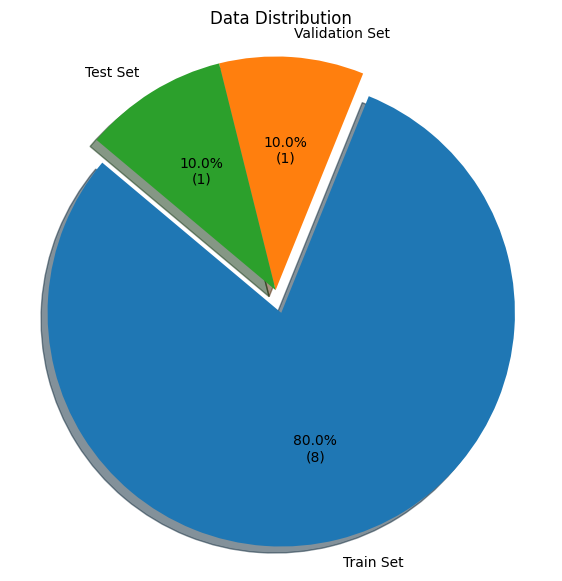

In [8]:
train_samples = len(list(train_set))
val_samples = len(list(val_set))
test_samples = len(list(test_set))

labels = ['Train Set', 'Validation Set', 'Test Set']
sizes = [train_samples, val_samples, test_samples]
explode = (0.1, 0, 0) 

def autopct_format(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), shadow=True, startangle=140)
plt.axis('equal')  
plt.title('Data Distribution')
plt.show()

In [9]:
def get_spectogram(waveform):
    spectogram=tf.signal.stft(
        signals=waveform,
        frame_length=255,
        frame_step=128
    )
    spectogram=tf.abs(spectogram)
    spectogram=spectogram[..., tf.newaxis]
    return spectogram

def make_spectogram_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [10]:
def plot_waveform(waveform, title='Waveform'):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_spectrogram(spectrogram, title='Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='inferno')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def plot_frequency_distribution(waveform, sr, title='Frequency Distribution'):
    f, Pxx_den = signal.periodogram(waveform, sr)
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx_den)
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

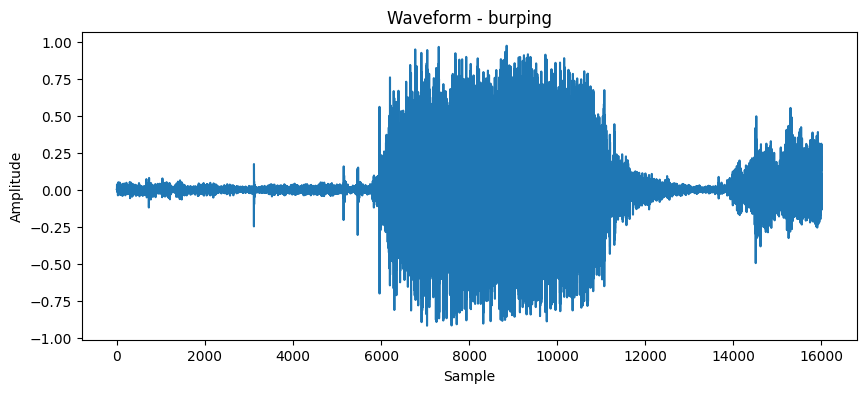

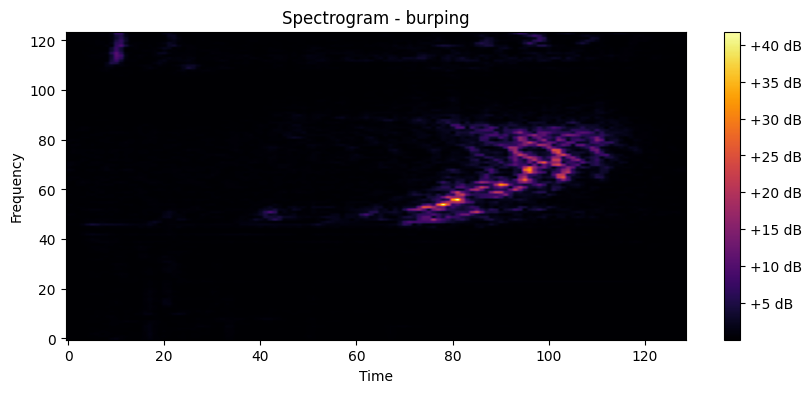

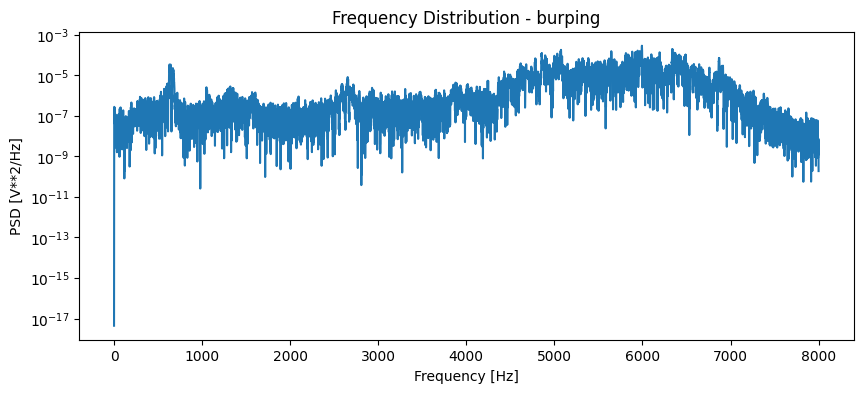

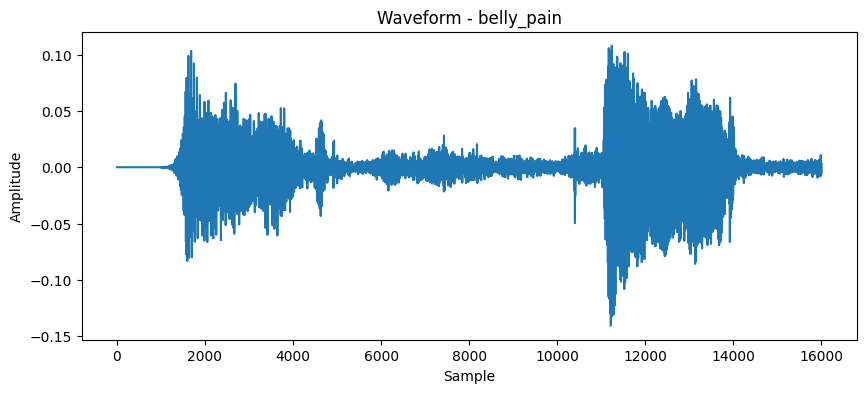

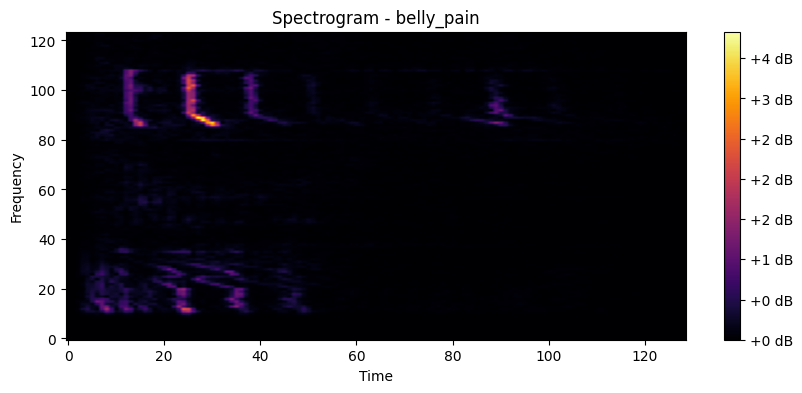

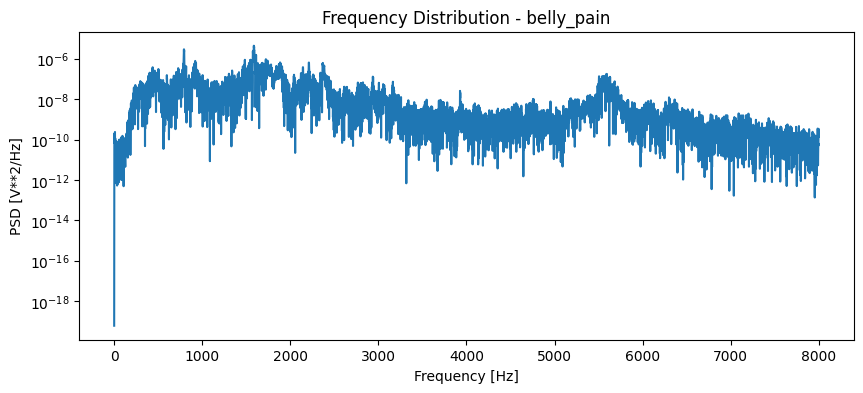

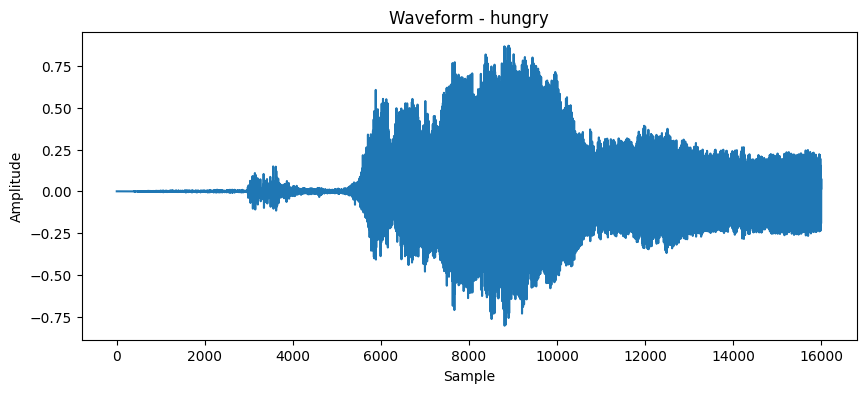

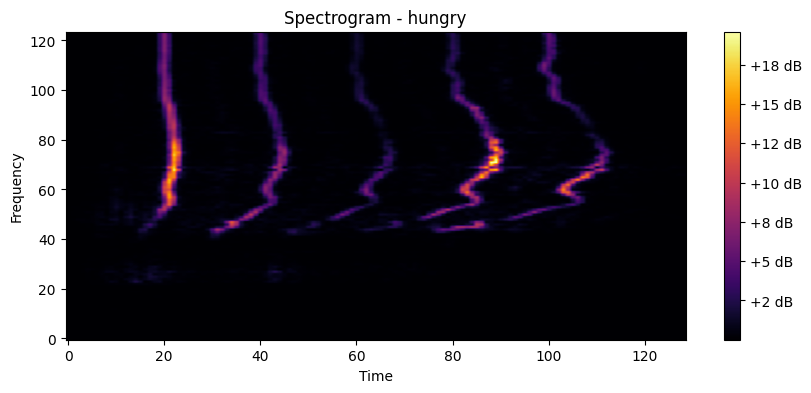

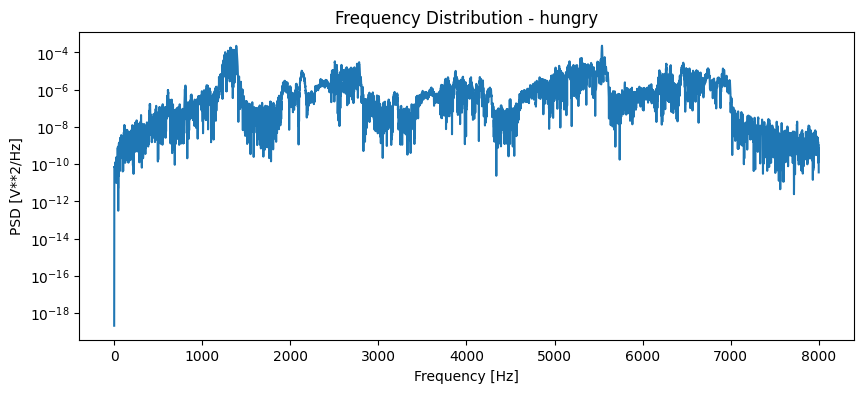

In [11]:
for audio, label in train_set.take(1):
    for i in range(3): 
        waveform = audio[i].numpy()
        label_str = label_names[label[i].numpy()]

        plot_waveform(waveform, title=f'Waveform - {label_str}')

        spectrogram = get_spectogram(waveform).numpy()
        spectrogram = np.squeeze(spectrogram)  
        plot_spectrogram(spectrogram, title=f'Spectrogram - {label_str}')

        plot_frequency_distribution(waveform, sr=16000, title=f'Frequency Distribution - {label_str}')

In [12]:
train_set_spec = make_spectogram_ds(train_set).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_set_spec = make_spectogram_ds(val_set).cache().prefetch(tf.data.AUTOTUNE)
test_set_spec = make_spectogram_ds(test_set).cache().prefetch(tf.data.AUTOTUNE)

In [13]:
for example_case, example_case_label in train_set_spec.take(1):
    break

In [14]:
input_shape = example_case.shape[1:]
num_label = len(cry_list)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_set_spec.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(num_label)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_set_spec,
    validation_data=val_set_spec,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=3, verbose=3)
)

Epoch 1/10
8/8 [==============================] - 2s 84ms/step - loss: 1.7775 - accuracy: 0.2377 - val_loss: 1.4873 - val_accuracy: 0.2857
Epoch 2/10
8/8 [==============================] - 0s 40ms/step - loss: 1.3951 - accuracy: 0.4344 - val_loss: 1.4382 - val_accuracy: 0.4286
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 1.2382 - accuracy: 0.5328 - val_loss: 1.2969 - val_accuracy: 0.5714
Epoch 4/10
8/8 [==============================] - 0s 42ms/step - loss: 1.0504 - accuracy: 0.5574 - val_loss: 1.2023 - val_accuracy: 0.5714
Epoch 5/10
8/8 [==============================] - 0s 40ms/step - loss: 1.0165 - accuracy: 0.6475 - val_loss: 1.1530 - val_accuracy: 0.5714
Epoch 6/10
8/8 [==============================] - 0s 37ms/step - loss: 0.8855 - accuracy: 0.6393 - val_loss: 1.1526 - val_accuracy: 0.5000
Epoch 7/10
8/8 [==============================] - 0s 41ms/step - loss: 0.7845 - accuracy: 0.6885 - val_loss: 1.2612 - val_accuracy: 0.5714
Epoch 8/10
8/8 [===========

In [17]:
model.save('cry_classification_model_scenario_1.h5')

In [18]:
ctr=0
for i , (spectogram, label) in enumerate(test_set_spec):
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    orig_label = label_names[label.numpy()]
    pred_label = [label_names[idx] for idx in pred_label_idx]
    for j, label in enumerate(orig_label):
        ctr+=1
        print(f'Data-{ctr}: label: {label} -> predicted: {pred_label[j]}') 
    

1/1 [==============================] - 0s 138ms/step
Data-1: label: tired -> predicted: tired
Data-2: label: belly_pain -> predicted: belly_pain
Data-3: label: belly_pain -> predicted: hungry
Data-4: label: tired -> predicted: tired
Data-5: label: burping -> predicted: burping
Data-6: label: tired -> predicted: discomfort
Data-7: label: hungry -> predicted: belly_pain
Data-8: label: discomfort -> predicted: discomfort
Data-9: label: discomfort -> predicted: discomfort
Data-10: label: hungry -> predicted: belly_pain
Data-11: label: tired -> predicted: tired
Data-12: label: discomfort -> predicted: tired
Data-13: label: discomfort -> predicted: belly_pain
Data-14: label: belly_pain -> predicted: belly_pain
Data-15: label: discomfort -> predicted: belly_pain
Data-16: label: tired -> predicted: belly_pain


In [19]:
test_result = model.evaluate(test_set_spec, return_dict=True)
accuracy = test_result['accuracy']
print(f"Accuracy = {round(accuracy * 100, 2)}%")

1/1 [==============================] - 0s 35ms/step - loss: 1.6084 - accuracy: 0.5000
Accuracy = 50.0%


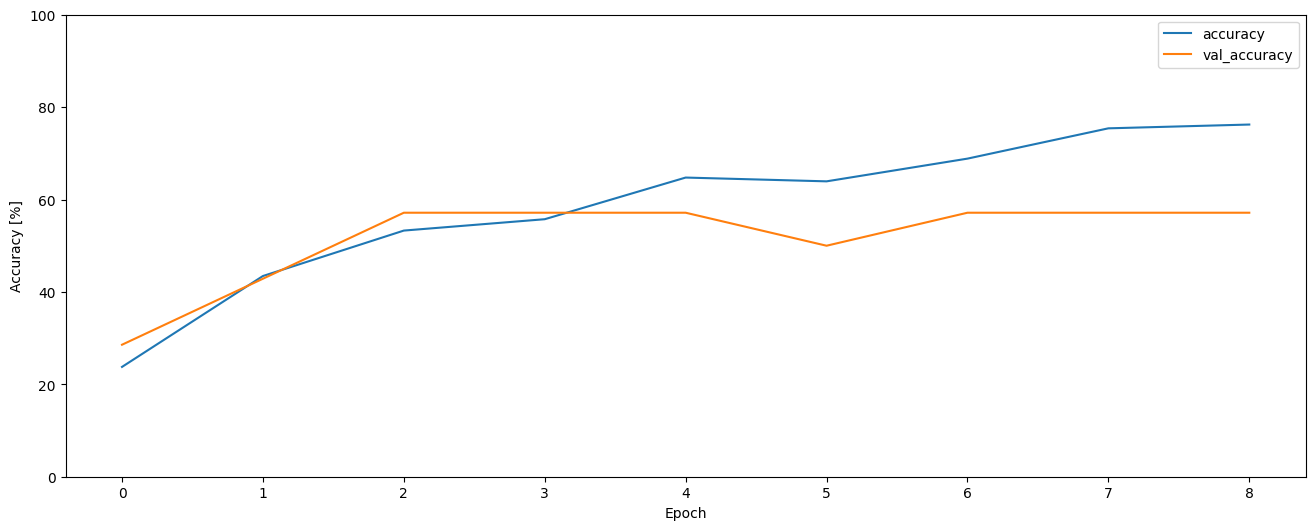

In [20]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [21]:
y_true = []
y_pred = []

for spectogram, label in test_set_spec:
    pred = model.predict(spectogram)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()
    y_true.extend(label.numpy())
    y_pred.extend(pred_label_idx)

y_true_names = [label_names[idx] for idx in y_true]
y_pred_names = [label_names[idx] for idx in y_pred]

precision = precision_score(y_true_names, y_pred_names, average='weighted')
recall = recall_score(y_true_names, y_pred_names, average='weighted')

print(f"Precision = {round(precision * 100, 2)}%")
print(f"Recall = {round(recall * 100, 2)}%")
print("Classification Report:")
print(classification_report(y_true_names, y_pred_names, labels=label_names))

1/1 [==============================] - 0s 45ms/step
Precision = 55.88%
Recall = 50.0%
Classification Report:
              precision    recall  f1-score   support

  belly_pain       0.29      0.67      0.40         3
     burping       1.00      1.00      1.00         1
  discomfort       0.67      0.40      0.50         5
      hungry       0.00      0.00      0.00         2
       tired       0.75      0.60      0.67         5

    accuracy                           0.50        16
   macro avg       0.54      0.53      0.51        16
weighted avg       0.56      0.50      0.50        16



Confusion Matrix:


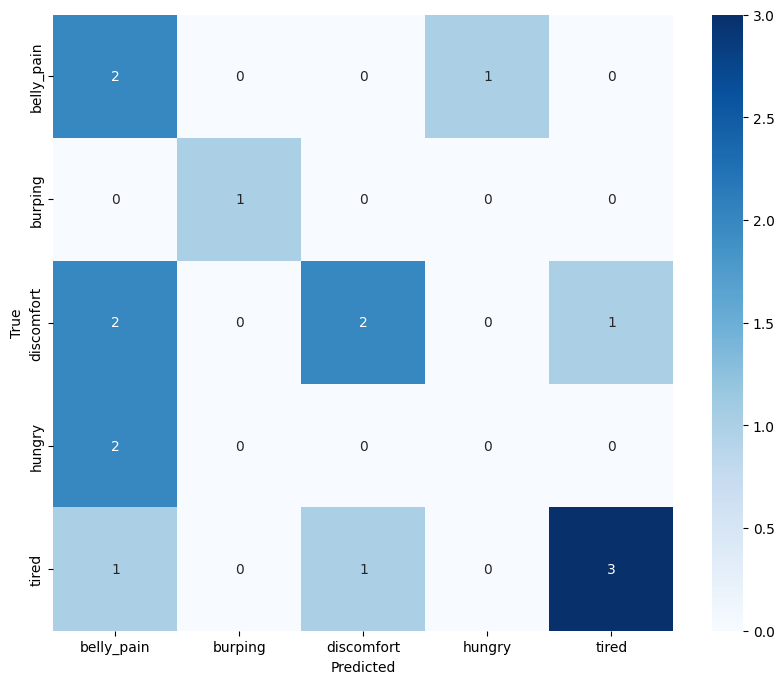

In [22]:
print("Confusion Matrix:")
cm = confusion_matrix(y_true_names, y_pred_names, labels=label_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
def preprocess_wav(audio_data_path):
    sample_rate, audio_data = wavfile.read(audio_data_path)
    audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    audio_tensor = audio_tensor / 32768.0
    pad_size = tf.maximum(0, 16000 - tf.shape(audio_tensor)[0])
    audio_tensor = tf.pad(audio_tensor, [[0, pad_size]], mode='CONSTANT')
    audio_tensor = tf.slice(audio_tensor, [0], [16000])
    spectrogram = tf.signal.stft(
        signals=audio_tensor,
        frame_length=255,
        frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return tf.expand_dims(spectrogram, axis=0)

In [25]:
model = tf.keras.models.load_model('cry_classification_model_scenario_1.h5')

audio_data_path = './input_test_tired/' + dir_test_audio

audio_data_preprocessed = preprocess_wav(audio_data_path)

logits = model.predict(audio_data_preprocessed)

probabilities = tf.nn.softmax(logits)

predicted_label_idx = tf.argmax(probabilities, axis=1).numpy()[0]
predicted_label = label_names[predicted_label_idx]

print(f'The predicted label: {predicted_label}')

print('\nLabel : Probability')
for i, label in enumerate(label_names):
    print(f'{label} : {probabilities.numpy()[0][i]}')

1/1 [==============================] - 0s 73ms/step
The predicted label: tired

Label : Probability
belly_pain : 0.1762702614068985
burping : 0.009428727440536022
discomfort : 0.06073576211929321
hungry : 0.028436187654733658
tired : 0.7251290082931519
